In [1]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
!pip install torch
!pip install tqdm
!pip install dotmap
import torch

In [0]:
# S = 40 # channel dim
# W = 32 # width
# H = 32 # height
# batch_size = 100
# padding = 4

# x = torch.arange(1, batch_size*S*W*H+1).view(batch_size, S, W, H)
# print(x.shape)
# x = torch.nn.functional.pad(x, (padding, padding, padding, padding))
# #print("x", x.shape, x)

# size = 5 # patch size
# stride = 1 # patch stride
# patches = x.float().unfold(1, S, stride).unfold(2, size, stride).unfold(3, size, stride)
# #print("patches", patches.shape, patches)
# print("patches", patches.shape)
# shape = patches.shape
# patches = patches.contiguous().view(shape[0], shape[1] * shape[2] * shape[3], shape[4] * shape[5] * shape[6])
# print(patches.shape)
# patches = patches.permute(0, 2, 1)
# print(patches.shape)

# # folded = torch.nn.functional.fold(input, self.output_size, self.kernel_size, self.dilation,
# #                       self.padding, self.stride)
# folded = torch.nn.functional.fold(patches, output_size=(W,H), kernel_size=size, stride=stride, padding=padding)
# folded = folded / (size * size)
# print(folded.shape)
# #print(folded / (size * size))

In [3]:
from dotmap import DotMap
import logging
import numpy as np
import os
import random
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm, tqdm_notebook
from scipy.stats import norm

# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"

logging.basicConfig(
    level=logging.ERROR,
    format='%(asctime)s.%(msecs)03d %(name)s:%(funcName)s %(levelname)s:%(message)s',
    datefmt="%M:%S")

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from skimage.draw import line_aa
%matplotlib inline
plt.style.use('classic')

from google.colab import drive
drive.mount('/content/gdrive')
save_path_prefix = '/content/gdrive/My Drive/Colab Notebooks/saved/13_'

def show_image(image, vmin=None, vmax=None, title=None, print_values=False, figsize=(4, 4)):
  #print("image ", image.shape)
  image = image.cpu().numpy()
  fig, ax1 = plt.subplots(figsize=figsize)
  if title:
    plt.title(title)
  #i = image.reshape((height, width))
  #print("i ", i.shape)
  ax1.imshow(image, vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma)
  plt.show()
  if print_values:
    print(image)

def show_image_grid(images, vmin=0, vmax=1, nrows=None, ncols=None, fig_width=30):
  s = images.shape

  assert len(s) == 3
  
  if nrows is None or ncols is None:
    resolution = int(s[0] ** 0.5)
    nrows = resolution
    ncols = resolution

  fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_width, fig_width * nrows / ncols),
                        subplot_kw={'xticks': [], 'yticks': []})

  fig.subplots_adjust(left=0.03, right=0.97, hspace=0, wspace=0)

  axs = axs.flat
  for i in np.arange(s[0]):
    axs[i].axis("off")
    axs[i].imshow(images[i].detach().cpu().numpy(), vmin=vmin, vmax=vmax, interpolation='none', cmap=plt.cm.plasma, aspect='auto')

  plt.tight_layout()
  plt.show()

def generate_bouncing_pixel(width, height, count=100):
  ball_width = 2
  x = 3 #random.randint(0, width)
  y = 2 #random.randint(0, height)
  dx = -1 #random.randint(0, 2) - 1
  dy = 1 #random.randint(0, 2) - 1
  
  images = []
  for _ in range(count):
    image = np.zeros((width, height))
    image[x, y] = 1.0
    image[x+1, y] = 1.0
    image[x, y+1] = 1.0
    image[x+1, y+1] = 1.0

    #image=gaussian_filter(image, 0.5)
    images.append(image)
    x += dx
    y += dy
    if (x < 0 or x > width - 1 - (ball_width - 1)):
      dx *= -1
      x += dx
    if (y < 0 or y > height - 1 - (ball_width - 1)):
      dy *= -1
      y += dy

  return torch.as_tensor(images)

def load_mnist(train=True, batch_size=64):
  kwargs = {'num_workers': 1, 'pin_memory': True} if device=="cuda" else {}
  loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=train, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)
  
  return loader

def conv_slice(x, kernel_size=5, padding=4, stride=1):
  print(f"conv_slice(x={x.shape}, kernel_size={kernel_size}, padding={padding}, stride={stride})")
  s = x.shape[1]
  padded_x = torch.nn.functional.pad(x, (padding, padding, padding, padding))
  print("conv_slice: padded_x", padded_x.shape)
  patches = padded_x.unfold(1, s, stride).unfold(2, kernel_size, stride).unfold(3, kernel_size, stride)
  print("conv_slice: patches", patches.shape)
  shape = patches.shape
  patches = patches.contiguous().view(shape[0], shape[1] * shape[2] * shape[3], shape[4] * shape[5] * shape[6])
  print("conv_slice: patches", patches.shape)
  patches = patches.view(-1, patches.shape[-1])
  print("conv_slice: patches", patches.shape)
  
  return patches

def conv_join(patches, image_count, image_size, kernel_size, stride, padding):
  assert len(patches.shape) == 2, "Patches must be (patch_count, patch_pixels)"
  
  patches = patches.view(image_count, -1, patches.shape[-1]) # (image_count, patches_per_image, patch_pixels)
  patches = patches.contiguous().permute(0, 2, 1)
  print(patches.shape)

  folded = torch.nn.functional.fold(patches, output_size=(image_size,image_size), kernel_size=kernel_size, stride=stride, padding=padding)
  folded = folded / (kernel_size * kernel_size)
  
  return folded

def keep_nonempty_patches(input):
  # input == 0 marks all zero elements as 1
  # (input == 0).sum(dim=1) sums up the above 1s for each patch.
  # If all pixels in a patch were zeros, then sum will be == patch size, i.e. input.shape[-1]
  # Use this mask to select nonempty patches and return
  return input[(input == 0).sum(dim=1) != input.shape[-1]]  # feature pdf results in sparse activations
  
  # The above will pass patches with even a single nonzero pixel
  # Let's be stricter and allow only those patches with majority nonzero pixels
  # Note: What we are trimming is conv padding. Actual image data will seldom have
  # true 0 values.
  # return input[(input == 0).sum(dim=1) <= input.shape[-1] / 2]


# Creates pdf for each item
# (input_count, feature_count, height, width) => (input_count, feature_count * resolution, height, width)
def to_pdf(mu, logvar, resolution=10):
  mu_shape = mu.shape
  input_count, feature_count, height, width = mu_shape
  step = 1.0 / (resolution + 1)

  assert mu_shape == logvar.shape
  assert resolution > 0
  assert resolution < 50
  
  # mu and logvar: move features to the end and flatten
  print("to_pdf: mu", mu.shape)
  mu_combined = mu.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: mu_combined", mu_combined.shape)

  var = logvar.exp()
  var = torch.clamp(var, step * 0.005, 3.0)
  
  var_combined = var.detach().permute(0, 2, 3, 1).contiguous().view(-1).cpu().numpy()
  print("to_pdf: var_combined", var_combined.shape)

  # pdf for each item
  rr = np.arange(step, 1, step)
  mu__ = torch.as_tensor([norm.pdf(rr, mu_combined[i], var_combined[i] * 100) for i in np.arange(mu_combined.shape[0])])
  print("to_pdf: mu__", mu__.shape) # (*, resolution)

  mu__ = mu__.view(-1, feature_count, resolution)
  print("to_pdf: mu__", mu__.shape) # (*, feature_count, resolution)

  mu__ = mu__.view(input_count, height, width, feature_count * resolution).contiguous()
  print("to_pdf: mu__", mu__.shape) # (input_count, height, width, feature_count * resolution)

  mu__ = mu__.permute(0, 3, 1, 2).contiguous() # (input_count, feature_count * resolution, height, width)
  print("to_pdf: mu__", mu__.shape)
  
  return mu__


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
class VAE(nn.Module):
  def __init__(self, input_size, feature_count):
    super(VAE, self).__init__()
    
    print(f"VAE(input_size={input_size}, feature_count={feature_count})")
    self.logger = logging.getLogger(self.__class__.__name__)
    self.logger.setLevel(logging.WARN)

    self.feature_count = feature_count

    self.encoder = nn.Sequential(
      nn.Linear(input_size    , input_size * 4),
      #nn.BatchNorm1d(num_features=input_size * 4),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Linear(input_size * 4, input_size),
      #nn.BatchNorm1d(num_features=input_size),
      nn.LeakyReLU(0.2, inplace=True),
    )

    self.decoder = nn.Sequential(
      nn.Linear(feature_count  , input_size * 4),
      #nn.BatchNorm1d(num_features=input_size * 4),
      nn.LeakyReLU(0.2, inplace=True),

      nn.Linear(input_size * 4  , input_size),
      #nn.BatchNorm1d(num_features=input_size),
      nn.Sigmoid(),
    )

    self.linear_mu = nn.Linear(input_size, feature_count)
    self.linear_sigma = nn.Linear(input_size, feature_count)

    self.lrelu = nn.LeakyReLU()
    self.relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.tanh = nn.Tanh()

  def encode(self, x):
    self.logger.debug(f"x {x.shape}")
    x = self.encoder(x)

    return self.sigmoid(self.linear_mu(x)), self.linear_sigma(x)

  def decode(self, z):
    self.logger.debug(f"z {z.shape}")
    return self.decoder(z)

  def reparametrize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    eps = torch.FloatTensor(std.size()).normal_().to(device)
    eps = eps.mul(std).add_(mu)
    eps = torch.sigmoid(eps)
    self.logger.debug(f"eps {eps.shape}")

    return eps

  def decode_features(self, mu, logvar):
    z = self.reparametrize(mu, logvar)
    self.logger.debug(f"z {z.shape}")
    decoded = self.decode(z)
    self.logger.debug(f"decoded {decoded.shape}")
    return decoded, z

  def forward(self, x):
    self.logger.debug(f"x {x.shape}")
    mu, logvar = self.encode(x)
    self.logger.debug(f"mu {mu.shape}")
    self.logger.debug(f"logvar {logvar.shape}")
    decoded, z = self.decode_features(mu, logvar)
    return decoded, mu, logvar, z


In [0]:
class Unit(nn.Module):
  def __init__(self, config, load_weights=True):
    super(Unit, self).__init__()
    self.config = config

    self.vae = VAE(self.config.input.features * self.config.resolution * self.config.kernel.height * self.config.kernel.width, self.config.output.features)
    self.trained = False

    if load_weights and os.path.exists(self.save_path()):
      self.load_state_dict(torch.load(self.save_path()))
      self.eval()
      self.trained = True

  def forward(self, x):
    return self.vae(x)

  def loss_function(self, recon_x, x, mu, logvar):
    # print(recon_x.size(), x.size())
    BCE = F.binary_cross_entropy(recon_x.view(-1, self.config.input.features * self.config.kernel.width * self.config.kernel.height), x.view(-1, self.config.input.features * self.config.kernel.width * self.config.kernel.height), size_average=True)
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # return BCE + KLD
    BCE /= 0.00001
    #print(BCE.item(), KLD.item())
    return BCE + KLD

  def train(self, images, training_config=None):
    training_config = training_config or self.config.training

    if self.trained:
      return

    if isinstance(images, bool):
      return

    print("images", images.shape)

    input = conv_slice(images, kernel_size=self.config.kernel.width, padding=self.config.padding.width, stride=training_config.stride.width)
    print("slices", input.shape)
    input = keep_nonempty_patches(input)
    show_image(images[0,0])
    print("input", input.shape)
    #for i in range(10):
    #  print(f"------------------------- SLICE {i} --------------------------")
    #  show_image(input[i].detach().view(self.config.input.features, self.config.kernel.height, self.config.kernel.width)[0], vmin=0, vmax=1, title=f"input slice {i}")

    optimizer = torch.optim.Adam(self.parameters(), lr=training_config.learning_rate, weight_decay=training_config.weight_decay)

    done = False
    dataset = torch.utils.data.TensorDataset(input)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=training_config.batch_size, shuffle=training_config.shuffle)

    epoch = 0

    with tqdm(total=training_config.num_epochs) as tqdm_epochs:
      for epoch in range(training_config.num_epochs):
        for i, batch in enumerate(data_loader):
          batch = batch[0].to(device)
          output, mu, logvar, z = self(batch)
          loss = self.loss_function(output, batch, mu, logvar)
          # ===================backward====================
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

        if epoch % int(training_config.num_epochs / 10) == 0:
          output, mu, logvar, z = self(input[0].unsqueeze(dim=0))
          tqdm_epochs.write('epoch [{}/{}], loss:{:.4f}'
               .format(epoch+1, training_config.num_epochs, loss.item()))
          print("output", output.shape)
          show_image(output[0].detach().view(self.config.input.features * self.config.resolution, self.config.kernel.height, self.config.kernel.width)[0], title=f"output 0, feature 0", vmin=0, vmax=1)

        if (loss.item() < 0.001 and epoch > 1500) or epoch > training_config.num_epochs:
          break

        tqdm_epochs.update(1)

    torch.save(self.state_dict(), self.save_path())

  def join_slices_into_images(self, slices, image_count, stride):
    return conv_join(slices, image_count=image_count, image_size=self.config.input.width, kernel_size=self.config.kernel.width, stride=stride, padding=self.config.padding.width)

  def eval_data(self, images, stride=None):
    stride = stride or self.config.training.stride.width

    # conv_slice(images) => slices
    input = conv_slice(images, kernel_size=self.config.kernel.width, padding=self.config.padding.width, stride=stride)

    # decoder(encoder(slices)) => slices_bar
    slices_bar, mu, logvar, z = self(input)

    # conv_join(slices) => images
    images_bar = self.join_slices_into_images(slices_bar, images.shape[0], stride=stride)

    return images_bar, slices_bar, mu, logvar, z

  def save_path(self):
    return f"{save_path_prefix}unit_{self.config.name}.pt"

  # assumes 4 features
  def explore_latent_space(self, resolution=6):
    ls = torch.linspace(0, 1, resolution)

    test_mu = torch.stack([torch.tensor([ls[i1], ls[i2], ls[i3], ls[i4]]) for i1 in np.arange(resolution) for i2 in np.arange(resolution) for i3 in np.arange(resolution) for i4 in np.arange(resolution)]).to(device)
    test_logvar = torch.ones(test_mu.size()).mul(-10).to(device)

    output, _ = self.vae.decode_features(test_mu, test_logvar)
    output = output.view(-1, self.config.kernel.height, self.config.kernel.width)

    show_image_grid(output)

  def up(self, images1, stride=None):
    stride = stride or self.config.training.stride.width

    # encode(images) => mu
    _, _, mu1, logvar1, _ = self.eval_data(images1, stride=stride)
    print("up: mu1", mu1.shape)
    
    output_image_count = images1.shape[0] # same as input image count
    mu1 = self._reshape_mu(mu1, output_image_count)
    print("up: mu1", mu1.shape)
    logvar1 = self._reshape_mu(logvar1, output_image_count)
    print("up: logvar1", logvar1.shape)
    
    images2 = to_pdf(mu1, logvar1, self.config.resolution).detach()
    padding = self.config.padding.width
    images2 = images2[:, :, padding:-padding, padding:-padding]

    print(images2.shape)
    show_image(images1[0, 0].detach(), vmin=0, vmax=1, title=f"images{self.config.name} 0")
    show_image(images2[0, 0].detach(), vmin=0, vmax=1, title=f"images_next 0")
    images2 = images2
    return images2

  # shape (input_count * height * width, feature_count) => (input_count, feature_count, height, width)
  def _reshape_mu(self, mu1, output_image_count):
    output_image_size = int((mu1.shape[0] / output_image_count) ** 0.5)
    feature_count = mu1.shape[1]
    assert output_image_count * output_image_size * output_image_size == mu1.shape[0]    
    mu1 = mu1.view(output_image_count, output_image_size, output_image_size, feature_count)
    mu1 = mu1.permute(0, 3, 1, 2).contiguous()
    return mu1
    
  def down(self, images2_bar, stride=None):
    # stride = stride or self.config.training.stride.width

    # flat_mu1_bar, flat_var1_bar = separate_mu_var_maps(images2_bar)

    # # unflatten(images2) => mu, varlog
    # mu1_bar = unflatten_features(flat_mu1_bar, a=self.a).to(device)
    # var1_bar = unflatten_features(flat_var1_bar, a=self.a).to(device)
    # varlog1_bar = torch.log(var1_bar)

    # # decode(mu, varlog) => slices
    # slices1_bar, _ = self.vae.decode_features(mu1_bar, varlog1_bar)
    # slices1_bar = slices1_bar.view(-1, self.config.kernel.height, self.config.kernel.width).detach()
    # show_image(slices1_bar[0])

    # # conv_join(slices) => images
    # slices1_bar = slices1_bar.view(images2_bar.shape[0], -1, slices1_bar.shape[1], slices1_bar.shape[2])
    # images1_bar = self.join_slices_into_images(slices1_bar, images2_bar.shape[0], stride_width=stride_width, stride_height=stride_height)

    # return images1_bar
    pass

def build_and_train_unit(config, images, num_epochs=4000, load_weights=True):
  unit = Unit(config=config, load_weights=load_weights).to(device)
  unit.train(images)
  reconstructed_images, reconstructed_slices, mu, logvar, z = unit.eval_data(images)
  return unit, reconstructed_images, reconstructed_slices, mu, logvar, z



# Unit 1

Processing...
Done!
mu0 torch.Size([100, 1, 28, 28])
to_pdf: mu torch.Size([100, 1, 28, 28])
to_pdf: mu_combined (78400,)
to_pdf: var_combined (78400,)
to_pdf: mu__ torch.Size([78400, 4])
to_pdf: mu__ torch.Size([78400, 1, 4])
to_pdf: mu__ torch.Size([100, 28, 28, 4])
to_pdf: mu__ torch.Size([100, 4, 28, 28])
VAE(input_size=100, feature_count=4)
conv_slice(x=torch.Size([100, 4, 28, 28]), kernel_size=5, padding=4, stride=1)
conv_slice: padded_x torch.Size([100, 4, 36, 36])
conv_slice: patches torch.Size([100, 1, 32, 32, 4, 5, 5])
conv_slice: patches torch.Size([100, 1024, 100])
conv_slice: patches torch.Size([102400, 100])
torch.Size([100, 100, 1024])


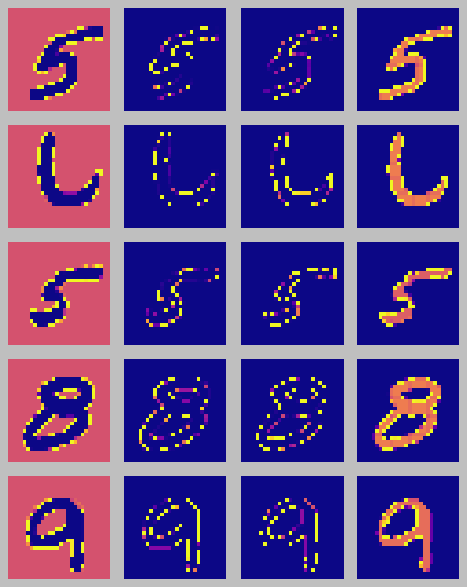

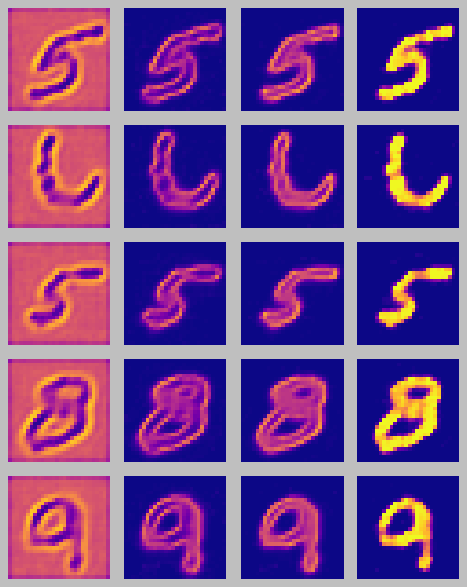

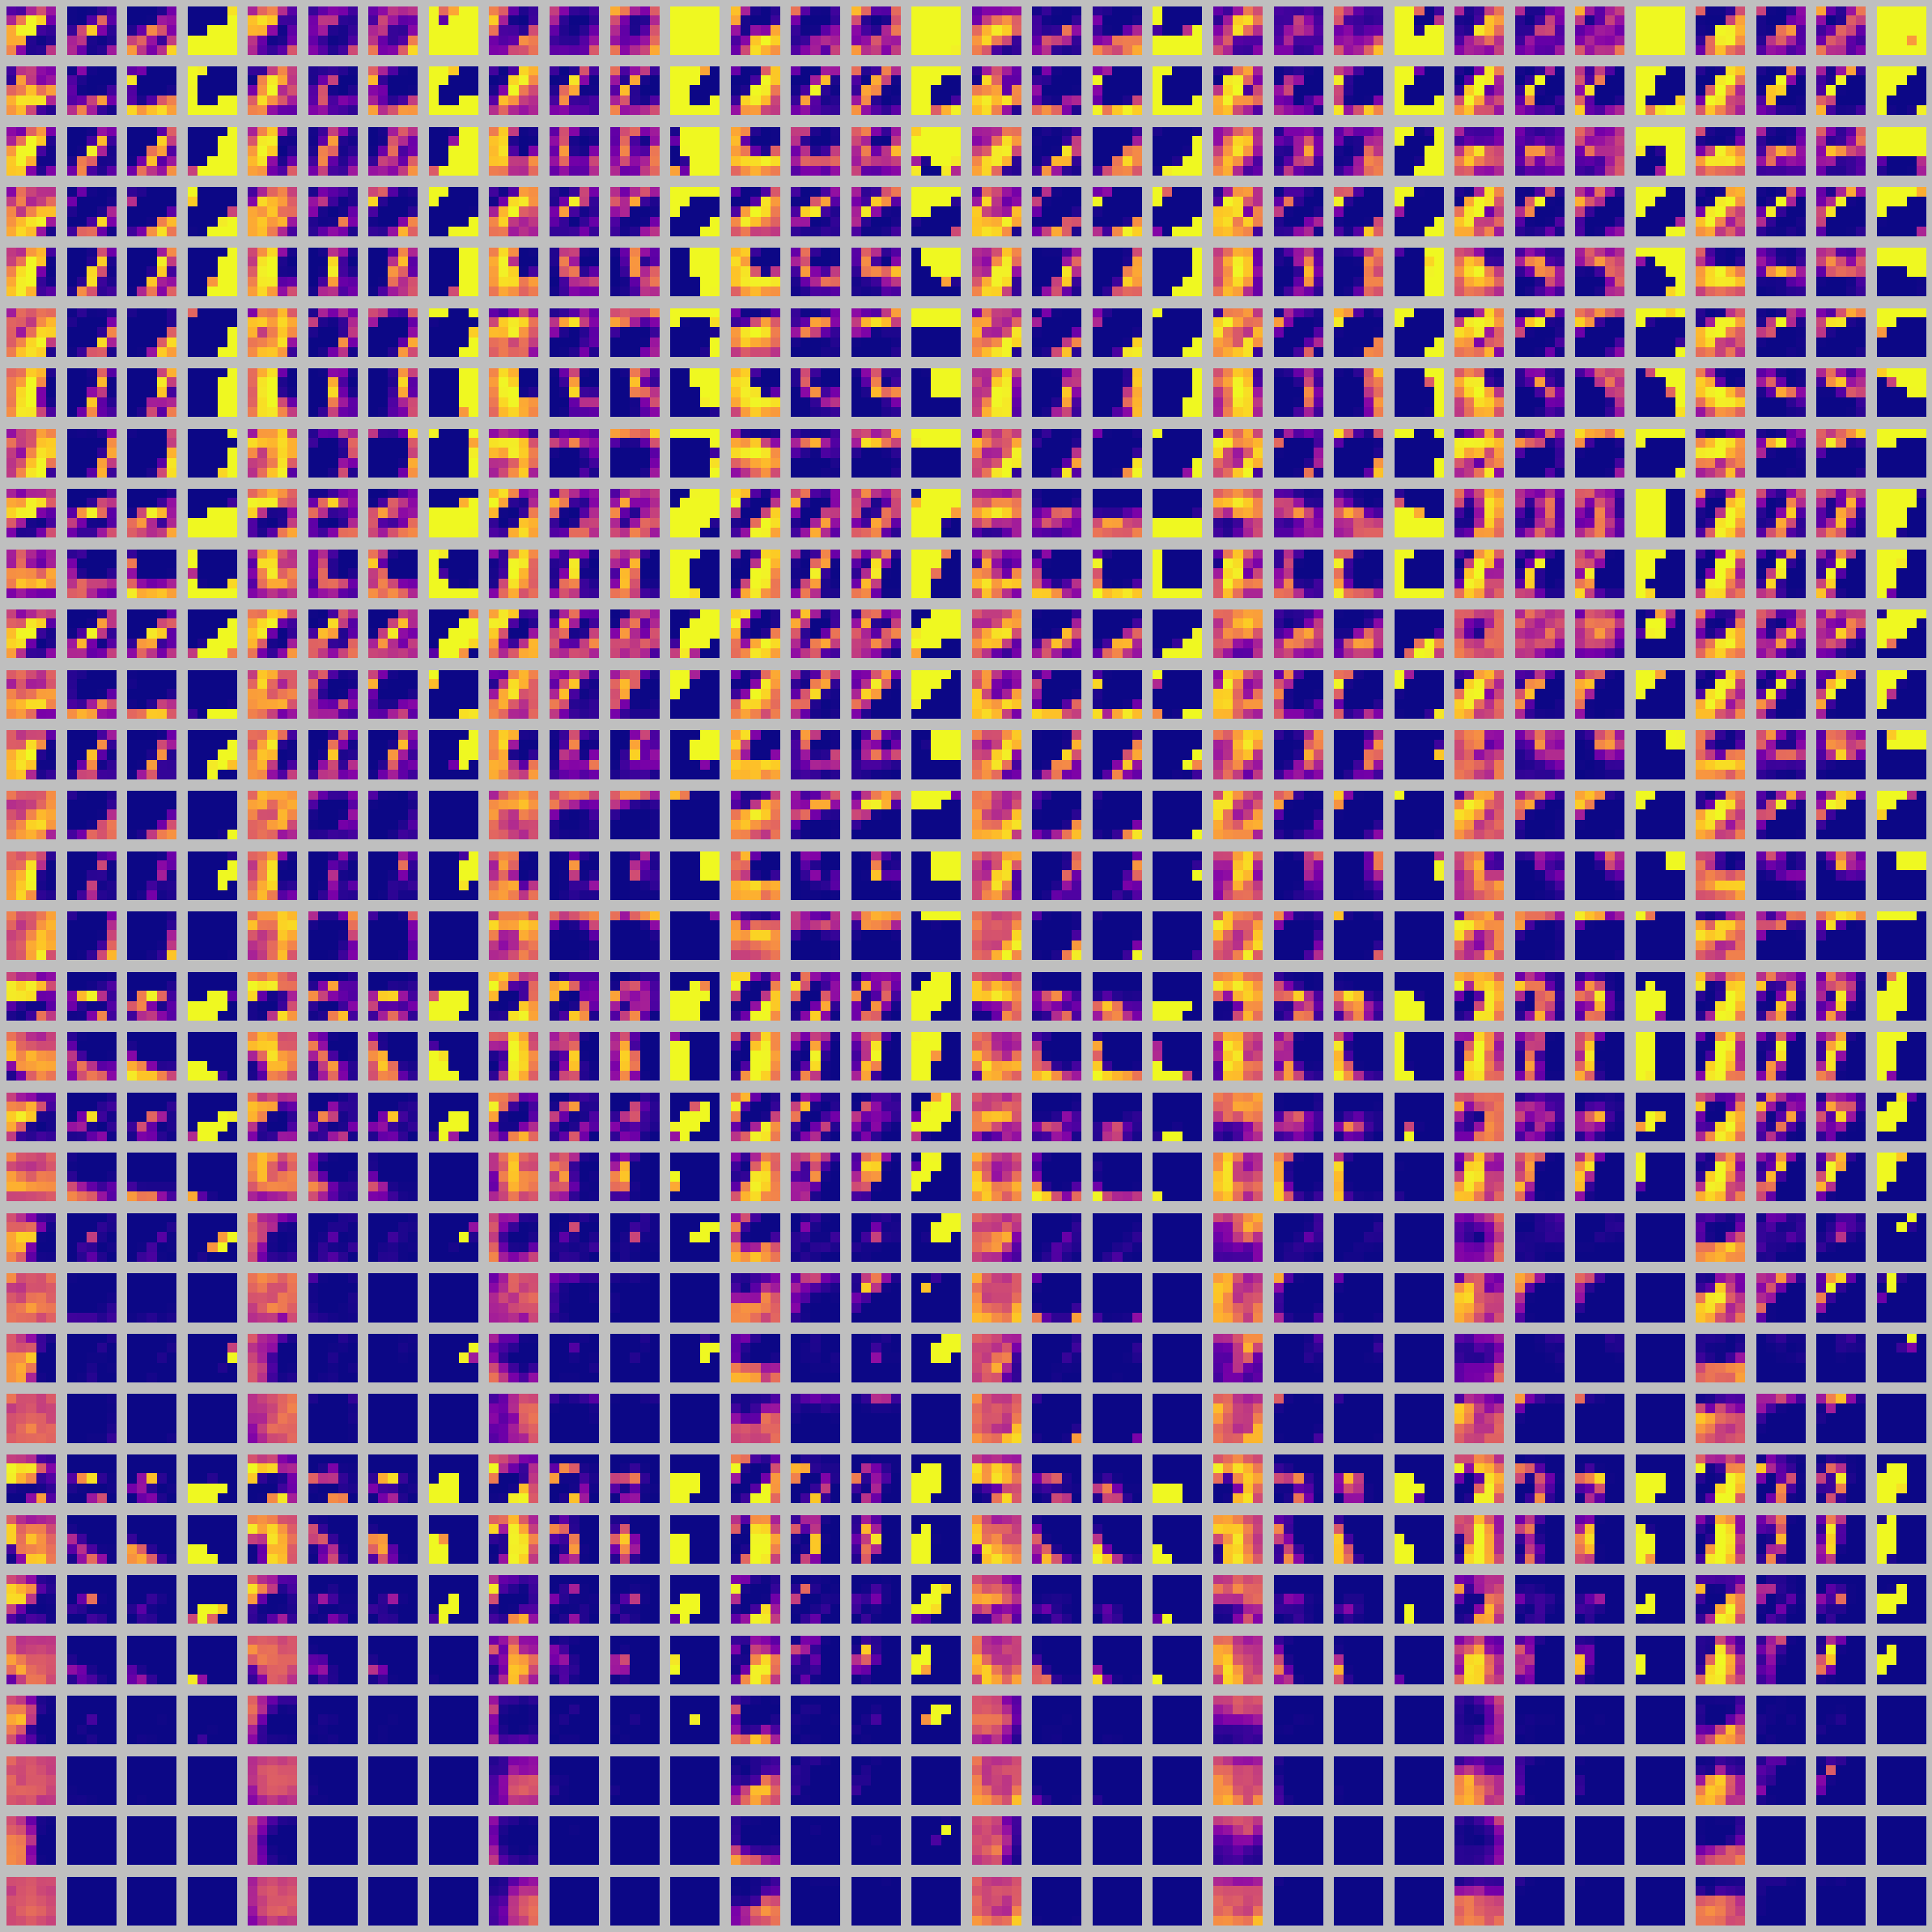

In [6]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

if False:
  import os
  import glob

  files = glob.glob(f"{save_path_prefix}*.pt")
  for f in files:
      os.remove(f)

# config for unit 1
config1 = DotMap({
  "name": "1",
  "input": {
    "count": 100,
    "features": 1,
    "width": 28,
    "height": 28,
  },
  "resolution": 4,
  "kernel": {
    "height": 5,
    "width": 5,
  },
  "padding": {
    "height": 4,
    "width": 4,
  },
  "output": {
    "features": 4
  },
  "training": {
    "stride": {
      "height": 1,
      "width": 1,
    },
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "batch_size": 256,
    "shuffle": True,
    "num_epochs": 100,
  },
})

mu0 = next(iter(load_mnist(batch_size=config1.input.count)))[0].to(device)
assert mu0.shape == (config1.input.count, config1.input.features, config1.input.width, config1.input.height)
print("mu0", mu0.shape)

logvar0 = torch.ones(mu0.size()).mul(-10).to(device)

images1 = to_pdf(mu0, logvar0, config1.resolution).float()
assert images1.shape == (config1.input.count, config1.input.features * config1.resolution, config1.input.width, config1.input.height)

#show_image_grid(images1[0:5, :].view(-1, images1.shape[-2], images1.shape[-1]), nrows=5, ncols=images1.shape[1], fig_width=10)

unit1, reconstructed_images1, reconstructed_slices1, mu1, logvar1, z1 = build_and_train_unit(config=config1, images=images1, num_epochs=400, load_weights=True)

show_image_grid(images1[0:5, :].view(-1, images1.shape[-2], images1.shape[-1]), nrows=5, ncols=images1.shape[1], fig_width=6)
show_image_grid(reconstructed_images1[0:5, :].view(-1, reconstructed_images1.shape[-2], reconstructed_images1.shape[-1]), nrows=5, ncols=reconstructed_images1.shape[1], fig_width=6)

# feature_index = 9
# for i in range(5):
#   print(f"------------------------- IMAGE {i} --------------------------")
#   show_image(images1[i, feature_index].detach(), vmin=0, vmax=1, title=f"images1 image {i}")
#   show_image(reconstructed_images1[i, feature_index].detach(), vmin=0, vmax=1, title=f"reconstructed_images1 {i}")
#   show_image(images1[i, feature_index]-reconstructed_images1[i, feature_index].detach(), title=f"diff1 {i}")

unit1.explore_latent_space(resolution=4)

# Unit 2

conv_slice(x=torch.Size([100, 4, 28, 28]), kernel_size=5, padding=4, stride=1)
conv_slice: padded_x torch.Size([100, 4, 36, 36])
conv_slice: patches torch.Size([100, 1, 32, 32, 4, 5, 5])
conv_slice: patches torch.Size([100, 1024, 100])
conv_slice: patches torch.Size([102400, 100])
torch.Size([100, 100, 1024])
up: mu1 torch.Size([102400, 4])
up: mu1 torch.Size([100, 4, 32, 32])
up: logvar1 torch.Size([100, 4, 32, 32])
to_pdf: mu torch.Size([100, 4, 32, 32])
to_pdf: mu_combined (409600,)
to_pdf: var_combined (409600,)
to_pdf: mu__ torch.Size([409600, 4])
to_pdf: mu__ torch.Size([102400, 4, 4])
to_pdf: mu__ torch.Size([100, 32, 32, 16])
to_pdf: mu__ torch.Size([100, 16, 32, 32])
torch.Size([100, 16, 24, 24])


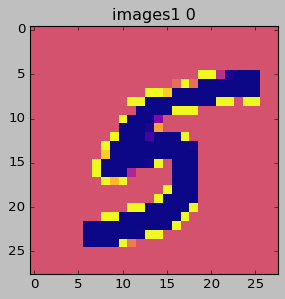

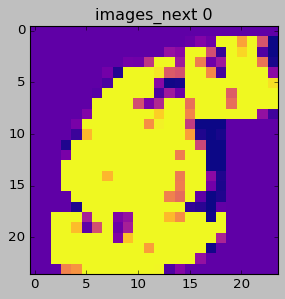

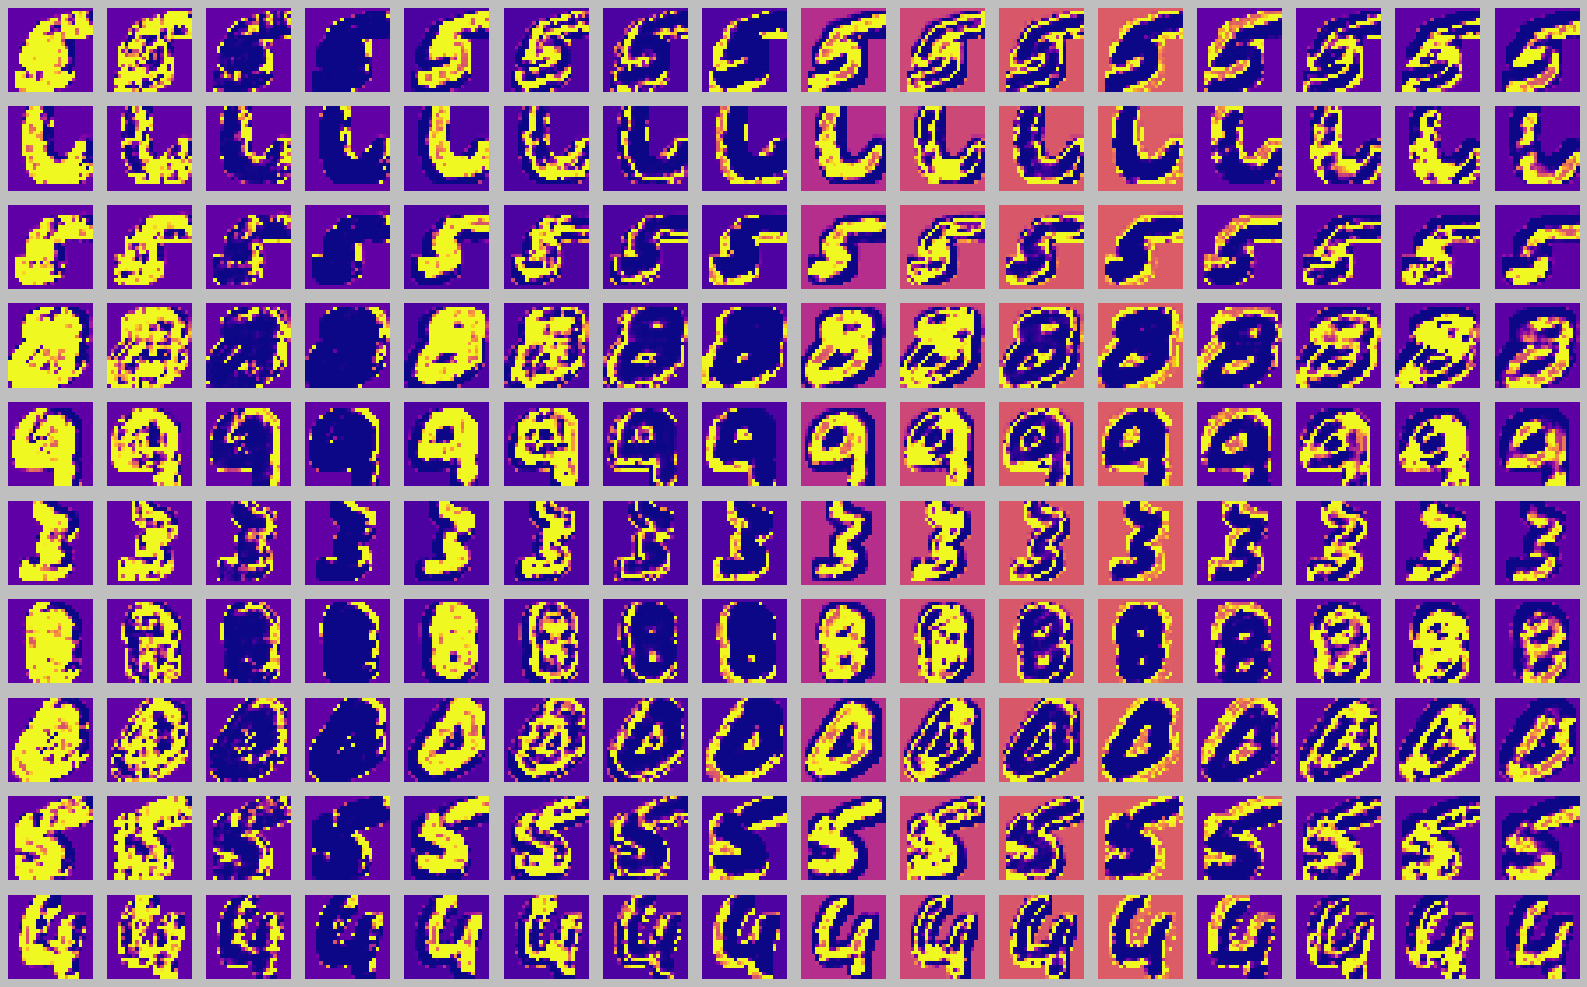

In [7]:
images2 = unit1.up(images1).detach().float().to(device)
show_image_grid(images2[0:10, :].view(-1, images2.shape[-2], images2.shape[-1]), nrows=10, ncols=images2.shape[1], fig_width=20)

VAE(input_size=784, feature_count=4)
conv_slice(x=torch.Size([100, 16, 24, 24]), kernel_size=7, padding=6, stride=1)
conv_slice: padded_x torch.Size([100, 16, 36, 36])
conv_slice: patches torch.Size([100, 1, 30, 30, 16, 7, 7])
conv_slice: patches torch.Size([100, 900, 784])
conv_slice: patches torch.Size([90000, 784])
torch.Size([100, 784, 900])


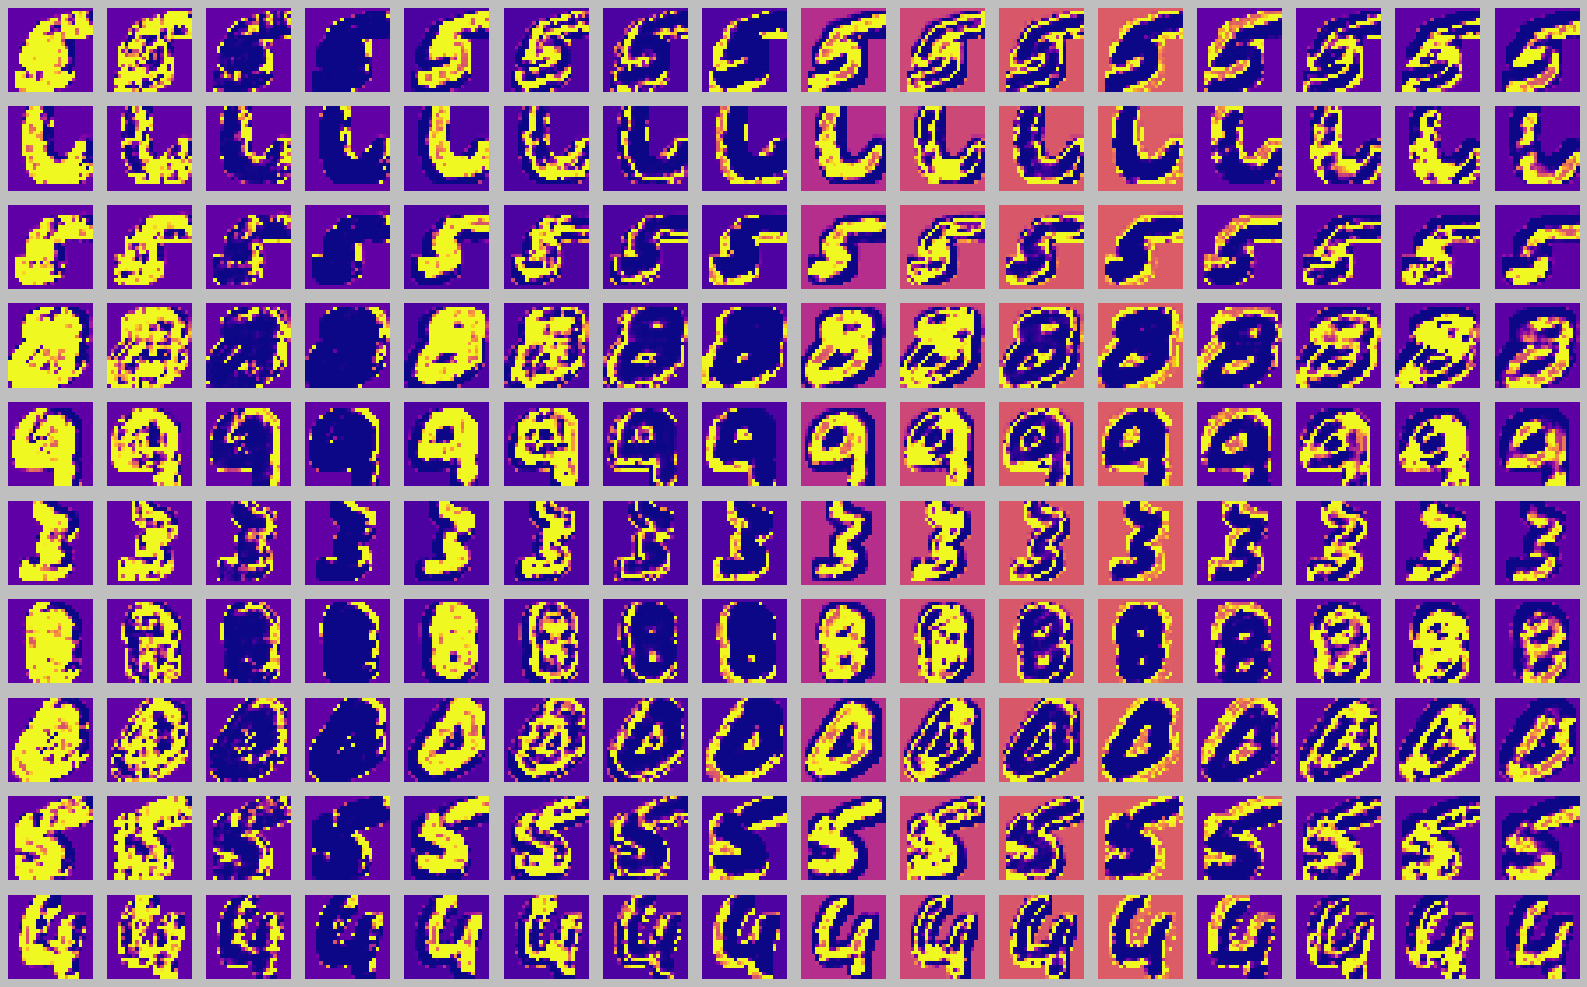

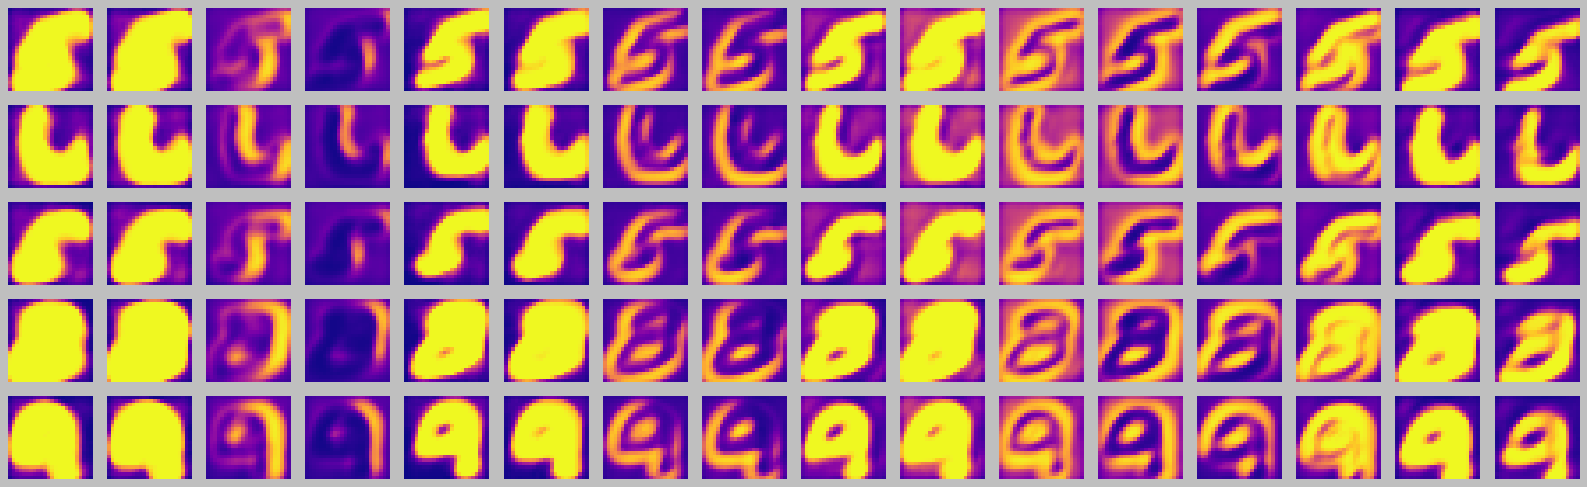

In [8]:
# config for unit 2
config2 = DotMap({
  "name": "2",
  "input": {
    "count": images2.shape[0],
    "features": int(images2.shape[1] / 4),
    "width": images2.shape[2],
    "height": images2.shape[3],
  },
  "resolution": 4,
  "kernel": {
    "height": 7,
    "width": 7,
  },
  "padding": {
    "height": 6,
    "width": 6,
  },
  "output": {
    "features": 4
  },
  "training": {
    "stride": {
      "height": 1,
      "width": 1,
    },
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "batch_size": 512,
    "shuffle": True,
    "num_epochs": 30,
  },
})

unit2, reconstructed_images2, reconstructed_slices2, mu2, logvar2, z2 = build_and_train_unit(config=config2, images=images2, load_weights=True)

show_image_grid(images2[0:10, :].view(-1, images2.shape[-2], images2.shape[-1]), nrows=10, ncols=images2.shape[1], fig_width=20)
show_image_grid(reconstructed_images2[0:5, :].view(-1, reconstructed_images2.shape[-2], reconstructed_images2.shape[-1]), nrows=5, ncols=reconstructed_images2.shape[1], fig_width=20)


# Unit 3

conv_slice(x=torch.Size([100, 16, 24, 24]), kernel_size=7, padding=6, stride=1)
conv_slice: padded_x torch.Size([100, 16, 36, 36])
conv_slice: patches torch.Size([100, 1, 30, 30, 16, 7, 7])
conv_slice: patches torch.Size([100, 900, 784])
conv_slice: patches torch.Size([90000, 784])
torch.Size([100, 784, 900])
up: mu1 torch.Size([90000, 4])
up: mu1 torch.Size([100, 4, 30, 30])
up: logvar1 torch.Size([100, 4, 30, 30])
to_pdf: mu torch.Size([100, 4, 30, 30])
to_pdf: mu_combined (360000,)
to_pdf: var_combined (360000,)
to_pdf: mu__ torch.Size([360000, 4])
to_pdf: mu__ torch.Size([90000, 4, 4])
to_pdf: mu__ torch.Size([100, 30, 30, 16])
to_pdf: mu__ torch.Size([100, 16, 30, 30])
torch.Size([100, 16, 18, 18])


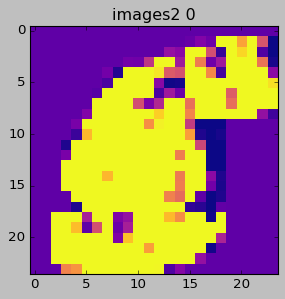

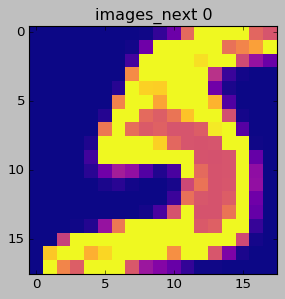

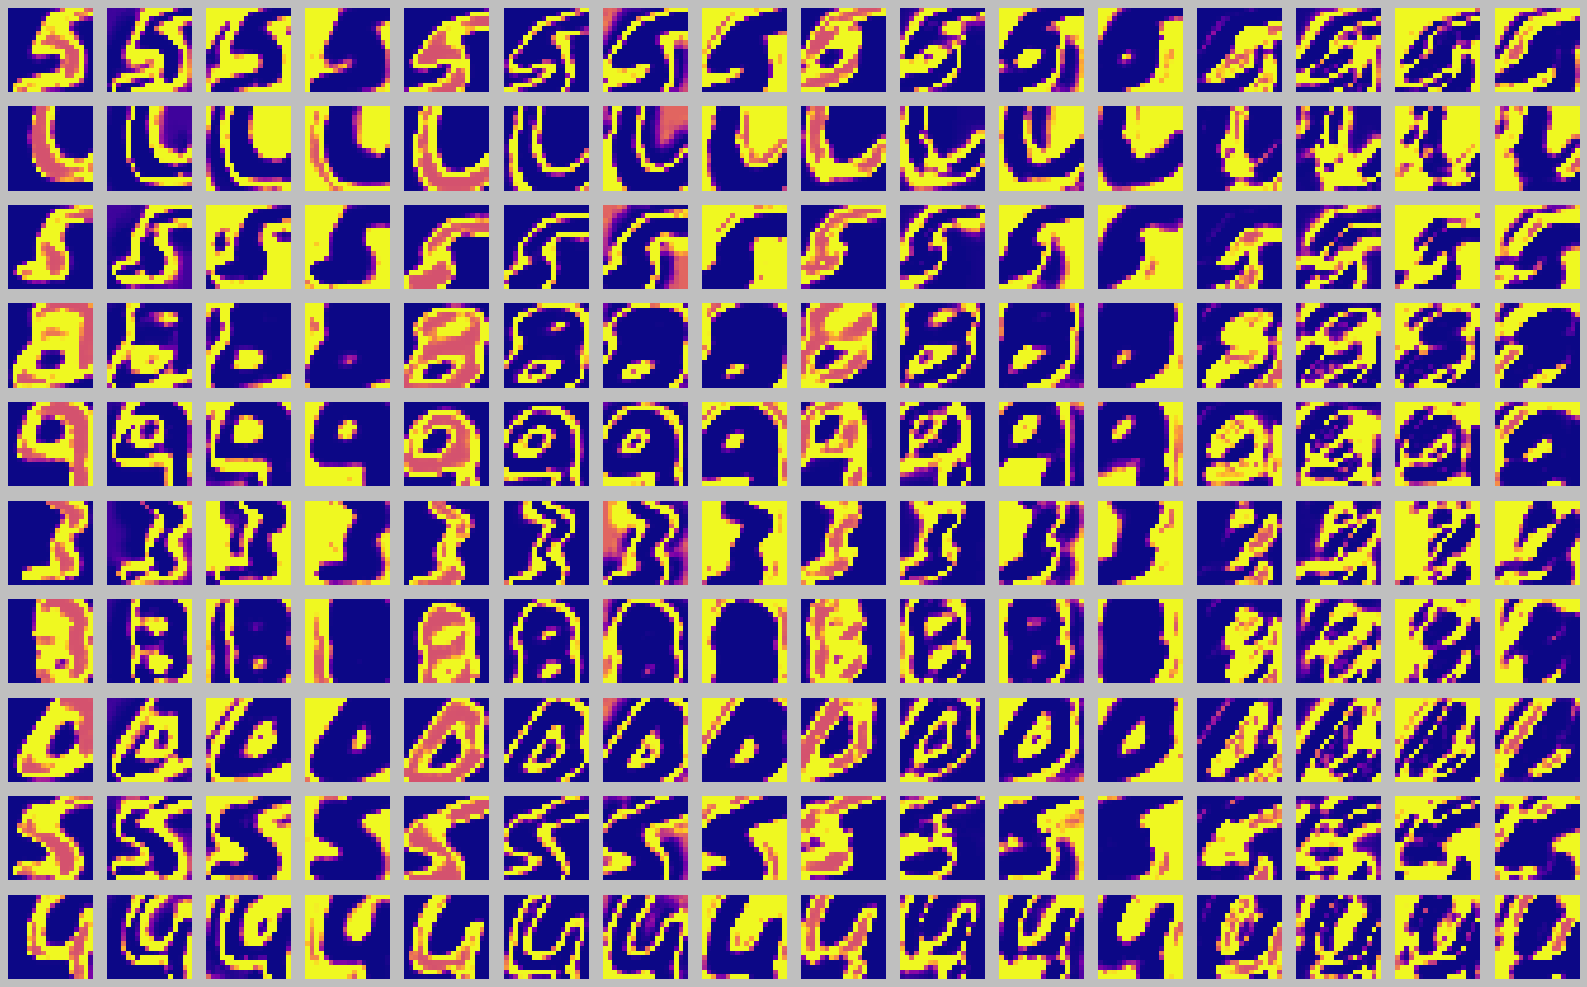

In [9]:
images3 = unit2.up(images2).detach().float().to(device)
show_image_grid(images3[0:10, :].view(-1, images3.shape[-2], images3.shape[-1]), nrows=10, ncols=images3.shape[1], fig_width=20)

VAE(input_size=784, feature_count=1)
conv_slice(x=torch.Size([100, 16, 18, 18]), kernel_size=7, padding=6, stride=1)
conv_slice: padded_x torch.Size([100, 16, 30, 30])
conv_slice: patches torch.Size([100, 1, 24, 24, 16, 7, 7])
conv_slice: patches torch.Size([100, 576, 784])
conv_slice: patches torch.Size([57600, 784])
torch.Size([100, 784, 576])


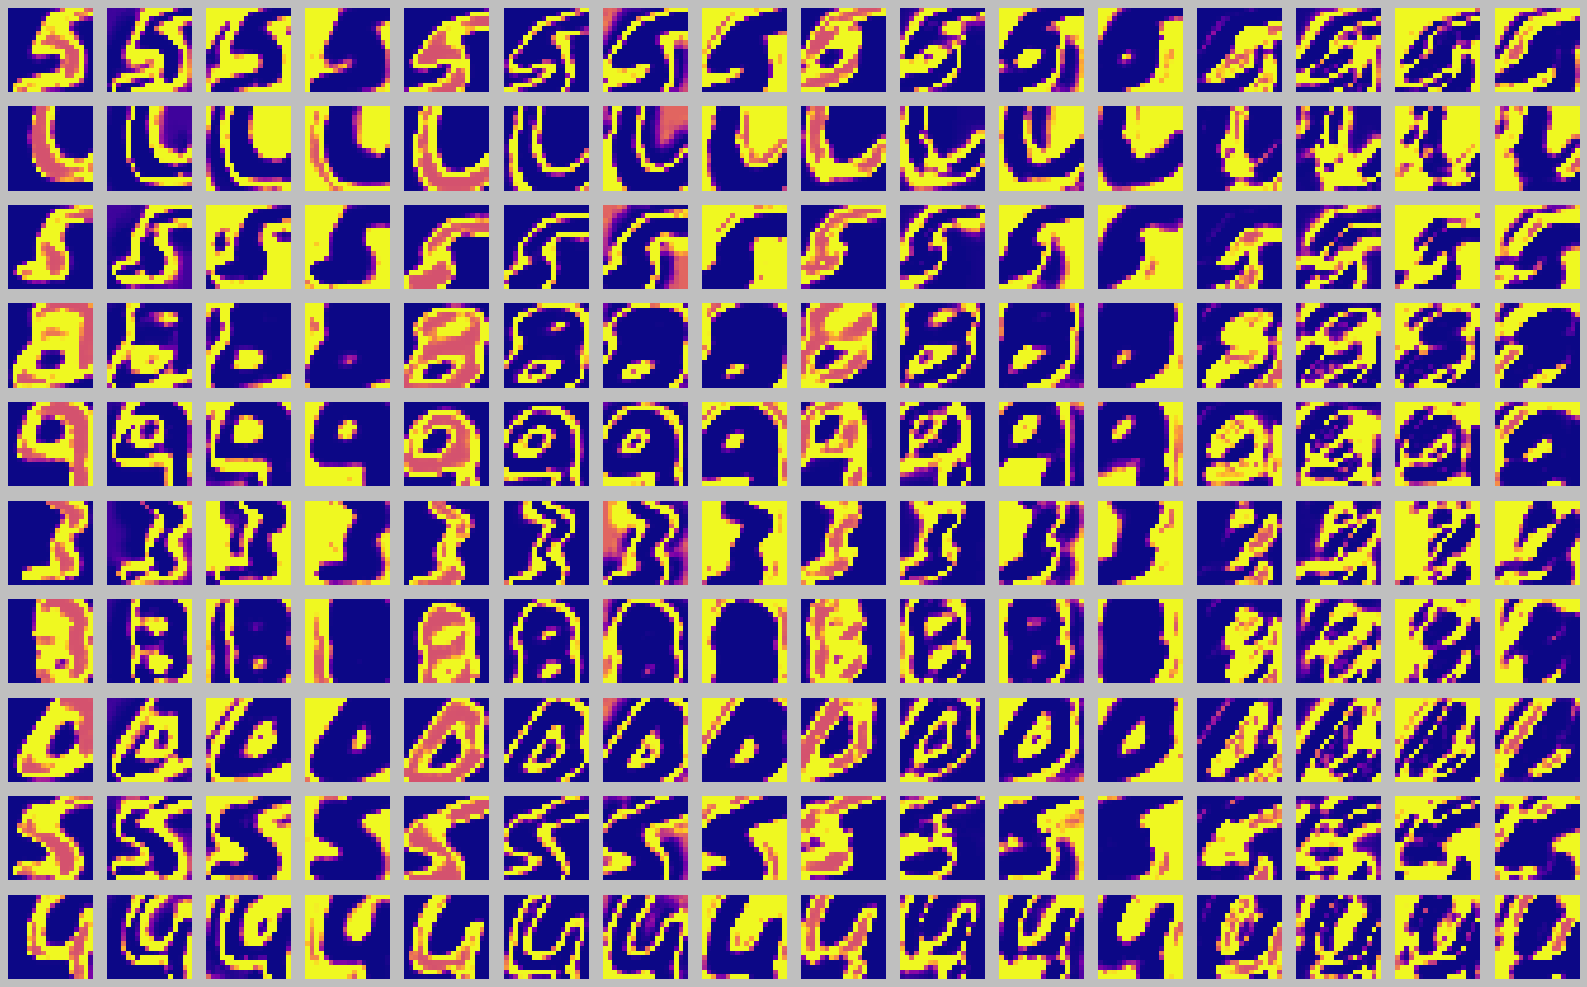

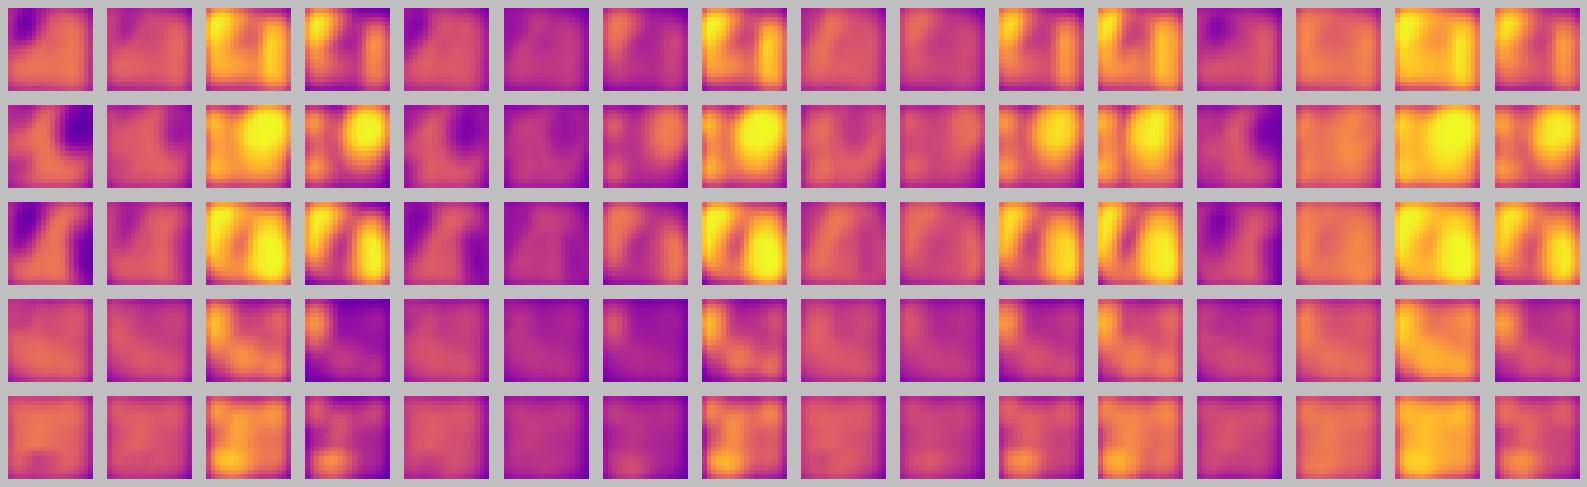

In [10]:
# config for unit 3
config3 = DotMap({
  "name": "3",
  "input": {
    "count": images3.shape[0],
    "features": int(images3.shape[1] / config2.resolution),
    "width": images3.shape[2],
    "height": images3.shape[3],
  },
  "resolution": 4,
  "kernel": {
    "height": 7,
    "width": 7,
  },
  "padding": {
    "height": 6,
    "width": 6,
  },
  "output": {
    "features": 1
  },
  "training": {
    "stride": {
      "height": 1,
      "width": 1,
    },
    "learning_rate": 1e-3,
    "weight_decay": 1e-5,
    "batch_size": 512,
    "shuffle": True,
    "num_epochs": 30,
  },
})

unit3, reconstructed_images3, reconstructed_slices3, mu3, logvar3, z3 = build_and_train_unit(config=config3, images=images3, load_weights=True)

show_image_grid(images3[0:10, :].view(-1, images3.shape[-2], images3.shape[-1]), nrows=10, ncols=images3.shape[1], fig_width=20)
show_image_grid(reconstructed_images3[0:5, :].view(-1, reconstructed_images3.shape[-2], reconstructed_images3.shape[-1]), nrows=5, ncols=reconstructed_images3.shape[1], fig_width=20)


# Unit 4

conv_slice(x=torch.Size([100, 16, 18, 18]), kernel_size=7, padding=6, stride=1)
conv_slice: padded_x torch.Size([100, 16, 30, 30])
conv_slice: patches torch.Size([100, 1, 24, 24, 16, 7, 7])
conv_slice: patches torch.Size([100, 576, 784])
conv_slice: patches torch.Size([57600, 784])
torch.Size([100, 784, 576])
up: mu1 torch.Size([57600, 1])
up: mu1 torch.Size([100, 1, 24, 24])
up: logvar1 torch.Size([100, 1, 24, 24])
to_pdf: mu torch.Size([100, 1, 24, 24])
to_pdf: mu_combined (57600,)
to_pdf: var_combined (57600,)
to_pdf: mu__ torch.Size([57600, 4])
to_pdf: mu__ torch.Size([57600, 1, 4])
to_pdf: mu__ torch.Size([100, 24, 24, 4])
to_pdf: mu__ torch.Size([100, 4, 24, 24])
torch.Size([100, 4, 12, 12])


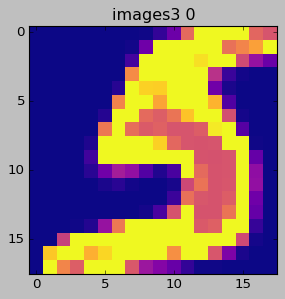

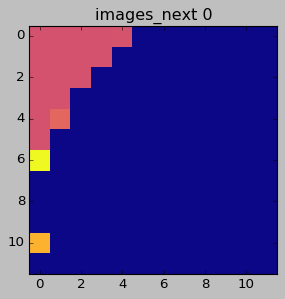

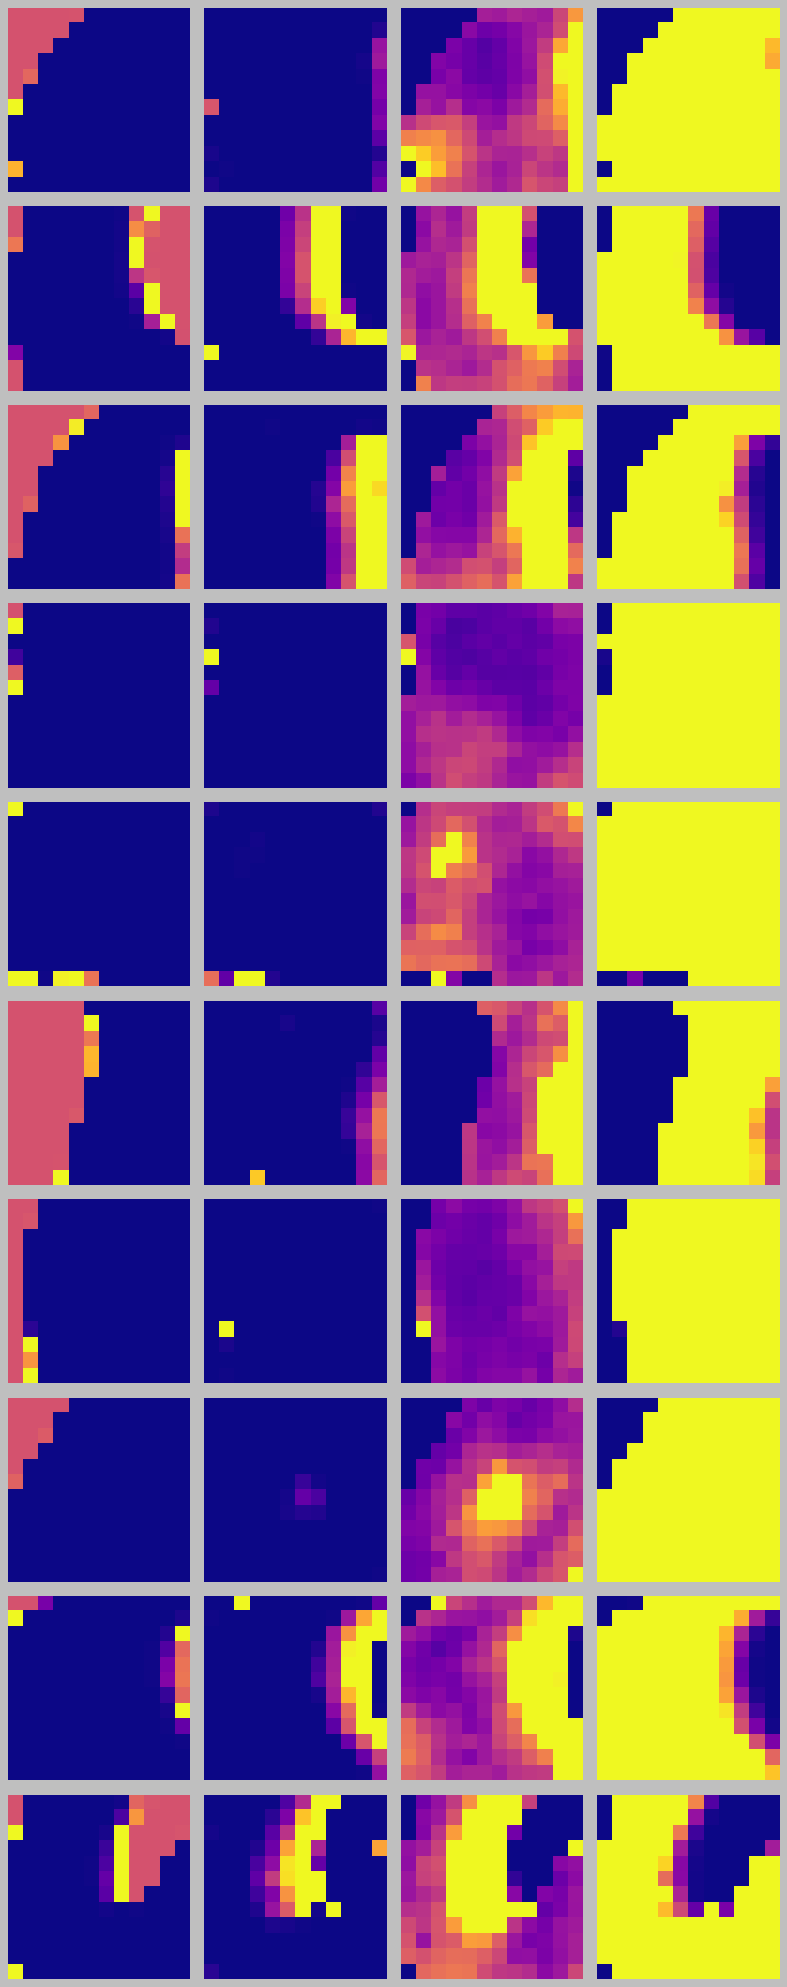

In [12]:
images4 = unit3.up(images3).detach().float().to(device)
show_image_grid(images4[0:10, :].view(-1, images4.shape[-2], images4.shape[-1]), nrows=10, ncols=images4.shape[1], fig_width=10)